### Import Necessary Packages

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime, timedelta

### Constant

In [10]:
train_start_dt = datetime(2017, 7, 1, 0, 0, 0)
train_end_dt = datetime(2020, 6, 30, 23, 0, 0)

TRAIN_DTS = {
    'BKK': {'start': datetime(2017, 7, 1, 6, 0, 0), 'end': datetime(2020, 6, 30, 23, 0, 0)},
    'Chiangmai': {'start': datetime(2017, 7, 1, 6, 0, 0), 'end': datetime(2020, 6, 30, 23, 0, 0)},
    'Khonkaen': {'start': datetime(2017, 10, 17, 18, 0, 0), 'end': datetime(2020, 6, 30, 23, 0, 0)},
    'Rayong': {'start': datetime(2017, 7, 1, 6, 0, 0), 'end': datetime(2020, 6, 30, 23, 0, 0)},
    'Saraburi': {'start': datetime(2017, 7, 1, 6, 0, 0), 'end': datetime(2020, 6, 30, 23, 0, 0)},
    'Surat': {'start': datetime(2018, 10, 1, 0, 0, 0), 'end': datetime(2020, 6, 30, 23, 0, 0)},
}

test_start_dt = datetime(2020, 7, 1, 0, 0, 0)
test_end_dt = datetime(2021, 7, 1, 23, 0, 0)

LOCS = ["BKK", "Chiangmai", "Khonkaen", "Rayong", "Saraburi", "Surat"]

base_processed_data_path = './processed_data'
base_dataset_path = './datasci_dataset_2022'

## General Functions

In [11]:
def get_current_dt():
    current_dt = datetime.now()
    return current_dt.strftime('%Y-%m-%d %H:%M:%S')

def read_processed_data(base_processed_data_path, mode):
    '''
    This function will read the processed data (csv) file with the given mode, and return a pandas DataFrame
    [Input]
        - base_processed_data_path: string containing folder of processed data path
        - mode: "temp" / "wind" / "hotspot"
    [Output]
        - df: pandas DataFrame
    '''
    
    df = pd.read_csv(f'{base_processed_data_path}/{mode}_processed_data.csv')

    df['date_time'] = pd.to_datetime(df['date_time'], format = '%Y-%m-%d %H:%M:%S')
    df.sort_values(by = 'date_time', inplace = True)
    df.drop_duplicates(inplace = True)
    
    return df

def read_PM25_data(base_dataset_path, province, train = True):
    '''
    This function will read the PM2.5 train/test data given in dataset with the corresponding province,
    and return a pandas DataFrame
    '''
    
    path = f'{base_dataset_path}/{province}'
    if (train):
        path += f'/train/{province.lower()}_train.csv'
    else:
        path += f'/test/{province.lower()}_test.csv'
        
    df = pd.read_csv(path)
    df.rename(columns = {df.columns[0]: 'date_time'}, inplace = True)
    df['date_time'] = pd.to_datetime(df['date_time'], format = '%Y-%m-%d %H:%M:%S')
    df.sort_values(by = 'date_time', inplace = True)
    df.drop_duplicates(inplace = True)
    
    return df

def save_train_test_result(base_processed_data_path, df, province, train = True):
    base_path = f'{base_processed_data_path}/{province}'
    # check if path exists (if not create it)
    if not os.path.exists(base_path):
        os.mkdir(base_path)
    
    # filename
    if (train):
        absolute_path = f'{base_path}/{province.lower()}_train.csv'
    else:
        absolute_path = f'{base_path}/{province.lower()}_test.csv'
    
    df.to_csv(absolute_path, index = False)
    

def change_resolution_to1H(df, start_dt, end_dt, freq = 'H'):
    daterange = pd.date_range(start = start_dt, end = end_dt, freq = freq).to_frame(name = 'date_time').reset_index(drop = True)
    df = pd.merge(daterange, df, on = 'date_time', how = 'outer')
    return df

def sample_df_freq(df, start_dt, end_dt, freq = '6h'):
    '''
    This function recieves a DataFrame change its resolution to freq given
    '''
    df = df.copy()
    df.set_index('date_time', inplace = True)
    df = df.reindex(pd.date_range(start_dt, end_dt, freq = freq), fill_value = np.nan)
    df.reset_index(inplace = True)
    df.rename(columns = {'index': 'date_time'}, inplace = True)
    return df

## Process PM2.5 Data

1. load the train/test PM2.5 data 
2. for the missing values 
    - in training data -> interpolate
    - in testing data -> use previous value
3. change resolution to 6H

In [12]:
def process_PM25_data(df_pm25_train, df_pm25_test, train_start_dt, train_end_dt, test_start_dt, test_end_dt):
    # ensure that the resolution of both the train/test data is 1H
    df_pm25_train = change_resolution_to1H(df_pm25_train, train_start_dt, train_end_dt)
    df_pm25_test = change_resolution_to1H(df_pm25_test, test_start_dt, test_end_dt)
    
    # for train data -> fill missing values by interpolation
    df_pm25_train['PM2.5'] = df_pm25_train['PM2.5'].interpolate().round(0)
    
    # for test data -> fill missing values with its previous value (avoid using future data)
    df_pm25_test['PM2.5'] = df_pm25_test['PM2.5'].interpolate(method = 'pad', limit_direction = 'forward')
    
    # change the resolution to 6H for further use to forecast
    df_pm25_train = sample_df_freq(df_pm25_train, train_start_dt, train_end_dt, freq = '6h')
    df_pm25_test = sample_df_freq(df_pm25_test, test_start_dt, test_end_dt, freq = '6h')
    
    df_pm25_processed = pd.concat([df_pm25_train, df_pm25_test], axis = 0) 
    return df_pm25_processed

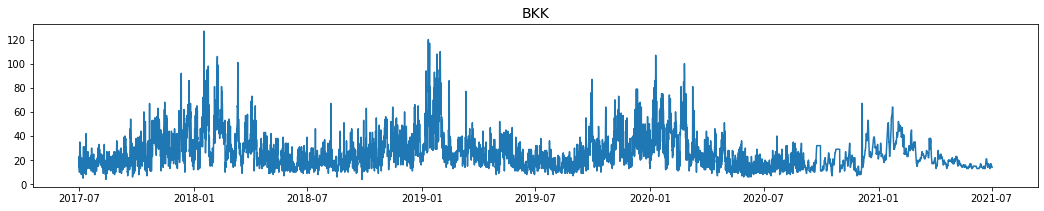

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5848 entries, 0 to 1463
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date_time  5848 non-null   datetime64[ns]
 1   PM2.5      5848 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 137.1 KB
None
               date_time  PM2.5
0    2017-07-01 00:00:00   14.0
1    2017-07-01 06:00:00   23.0
2    2017-07-01 12:00:00   15.0
3    2017-07-01 18:00:00   10.0
4    2017-07-02 00:00:00   17.0
...                  ...    ...
1459 2021-06-30 18:00:00   15.0
1460 2021-07-01 00:00:00   15.0
1461 2021-07-01 06:00:00   14.0
1462 2021-07-01 12:00:00   14.0
1463 2021-07-01 18:00:00   14.0

[5848 rows x 2 columns]


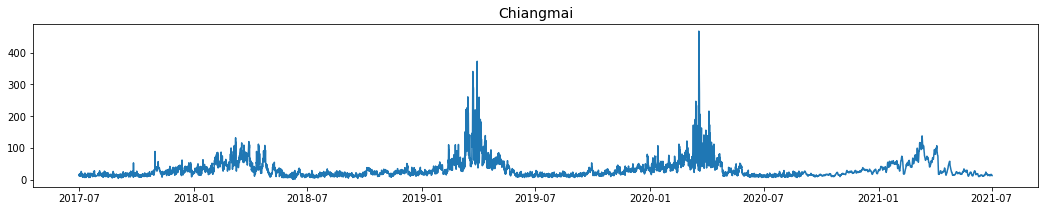

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5848 entries, 0 to 1463
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date_time  5848 non-null   datetime64[ns]
 1   PM2.5      5848 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 137.1 KB
None
               date_time  PM2.5
0    2017-07-01 00:00:00   13.0
1    2017-07-01 06:00:00   16.0
2    2017-07-01 12:00:00   15.0
3    2017-07-01 18:00:00   18.0
4    2017-07-02 00:00:00   17.0
...                  ...    ...
1459 2021-06-30 18:00:00   15.0
1460 2021-07-01 00:00:00   15.0
1461 2021-07-01 06:00:00   14.0
1462 2021-07-01 12:00:00   13.0
1463 2021-07-01 18:00:00   13.0

[5848 rows x 2 columns]


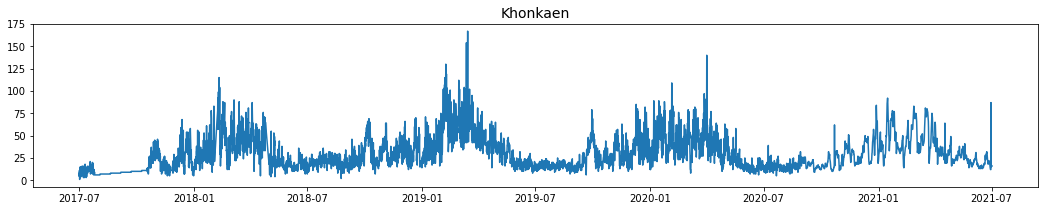

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5848 entries, 0 to 1463
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date_time  5848 non-null   datetime64[ns]
 1   PM2.5      5848 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 137.1 KB
None
               date_time  PM2.5
0    2017-07-01 00:00:00    5.0
1    2017-07-01 06:00:00    8.0
2    2017-07-01 12:00:00    5.0
3    2017-07-01 18:00:00   11.0
4    2017-07-02 00:00:00    1.0
...                  ...    ...
1459 2021-06-30 18:00:00   16.0
1460 2021-07-01 00:00:00   16.0
1461 2021-07-01 06:00:00   16.0
1462 2021-07-01 12:00:00   16.0
1463 2021-07-01 18:00:00   16.0

[5848 rows x 2 columns]


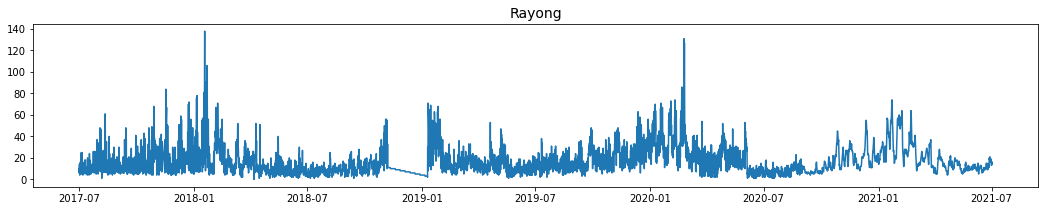

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5848 entries, 0 to 1463
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date_time  5848 non-null   datetime64[ns]
 1   PM2.5      5848 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 137.1 KB
None
               date_time  PM2.5
0    2017-07-01 00:00:00   10.0
1    2017-07-01 06:00:00    6.0
2    2017-07-01 12:00:00    6.0
3    2017-07-01 18:00:00   14.0
4    2017-07-02 00:00:00    9.0
...                  ...    ...
1459 2021-06-30 18:00:00   13.0
1460 2021-07-01 00:00:00   14.0
1461 2021-07-01 06:00:00   16.0
1462 2021-07-01 12:00:00   14.0
1463 2021-07-01 18:00:00   16.0

[5848 rows x 2 columns]


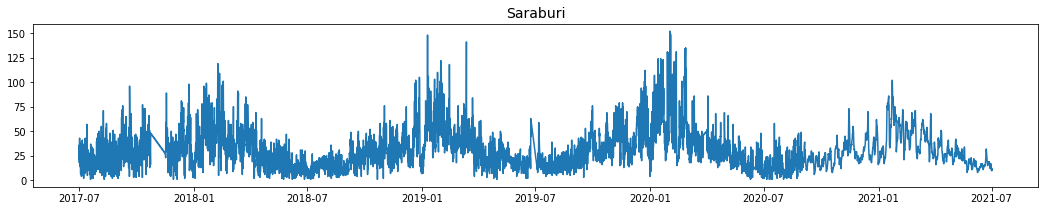

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5848 entries, 0 to 1463
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date_time  5848 non-null   datetime64[ns]
 1   PM2.5      5848 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 137.1 KB
None
               date_time  PM2.5
0    2017-07-01 00:00:00   22.0
1    2017-07-01 06:00:00   36.0
2    2017-07-01 12:00:00   18.0
3    2017-07-01 18:00:00   20.0
4    2017-07-02 00:00:00   43.0
...                  ...    ...
1459 2021-06-30 18:00:00   10.0
1460 2021-07-01 00:00:00   10.0
1461 2021-07-01 06:00:00   11.0
1462 2021-07-01 12:00:00   10.0
1463 2021-07-01 18:00:00   12.0

[5848 rows x 2 columns]


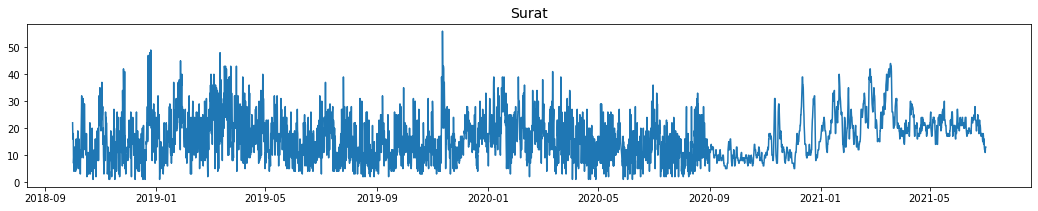

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4020 entries, 0 to 1463
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date_time  4020 non-null   datetime64[ns]
 1   PM2.5      4020 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 94.2 KB
None
               date_time  PM2.5
0    2018-10-01 00:00:00   22.0
1    2018-10-01 06:00:00   16.0
2    2018-10-01 12:00:00   16.0
3    2018-10-01 18:00:00   18.0
4    2018-10-02 00:00:00    7.0
...                  ...    ...
1459 2021-06-30 18:00:00   12.0
1460 2021-07-01 00:00:00   11.0
1461 2021-07-01 06:00:00   11.0
1462 2021-07-01 12:00:00   13.0
1463 2021-07-01 18:00:00   13.0

[4020 rows x 2 columns]


In [13]:
dfs_pm25_processed = {}

for province in LOCS:
    df_pm25_train = read_PM25_data(base_dataset_path, province, train = True)
    df_pm25_test = read_PM25_data(base_dataset_path, province, train = False)
    
    # for 'Surat' province
    if (province == 'Surat'):
        df_pm25_processed = process_PM25_data(df_pm25_train, df_pm25_test, datetime(2018, 10, 1, 0, 0, 0), train_end_dt, test_start_dt, test_end_dt)
    else:
         df_pm25_processed = process_PM25_data(df_pm25_train, df_pm25_test, train_start_dt, train_end_dt, test_start_dt, test_end_dt)
    
    dfs_pm25_processed[province] = df_pm25_processed

for province in LOCS:
    plt.figure(figsize = (18, 3))
    plt.plot(dfs_pm25_processed[province]['date_time'], dfs_pm25_processed[province]['PM2.5'], label = 'PM2.5')
    plt.title(province, fontsize = 14)
    plt.show()
    print(dfs_pm25_processed[province].info())
    print(dfs_pm25_processed[province])

เนื่องจากใน จ. ขอนแก่น เมื่อ plot กราฟออกมาแล้ว สังเกตว่าในช่วงต้นจะมีข้อมูลที่หายไปค่อนข้างเยอะ ดังนั้นสำหรับ จ. ขอนแก่น เราจะตัด training data ในช่วงต้นที่มีข้อมูลหายเยอะ ๆ ออก (ตั้งแต่ 2017-07-01 00:00:00 จนถึง 2017-10-17 13:00:00')

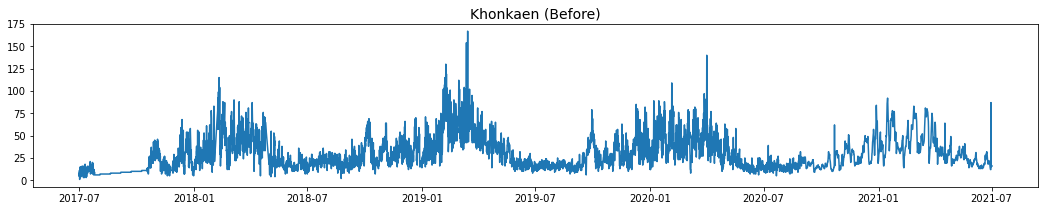

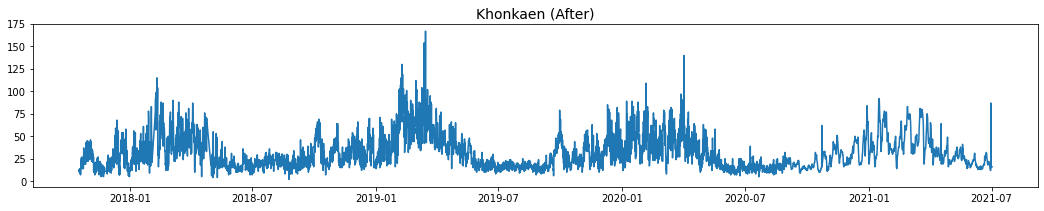

In [14]:
plt.figure(figsize = (18, 3))
plt.plot(dfs_pm25_processed['Khonkaen']['date_time'], dfs_pm25_processed['Khonkaen']['PM2.5'], label = 'PM2.5')
plt.title('Khonkaen (Before)', fontsize = 14)
plt.show()

dfs_pm25_processed['Khonkaen'] = dfs_pm25_processed['Khonkaen'][dfs_pm25_processed['Khonkaen']['date_time'] >= '2017-10-17 14:00:00']
plt.figure(figsize = (18, 3))
plt.plot(dfs_pm25_processed['Khonkaen']['date_time'], dfs_pm25_processed['Khonkaen']['PM2.5'], label = 'PM2.5')
plt.title('Khonkaen (After)', fontsize = 14)
plt.show()

## Process Training and Testing Data

นำข้อมูล wind, temp, hotspot ที่ทำการ processed มารวมกับ pm2.5 แล้วทำการ split save แยกเป็น train / test ของแต่ละจังหวัด

In [15]:
def process_train_test_data(province, df_pm25, df_wind, df_temp, df_hotspot, train_start_dt, train_end_dt, test_start_dt, test_end_dt, enable_feature_engineer = True):
    wind_cols = ['date_time'] + [f'wind_speed_{province}', f'wind_dir_{province}']
    temp_cols = ['date_time'] + [f'temp_{province}']
    hotspot_cols = df_hotspot.columns
    
    df = df_pm25.copy()
    df = pd.merge(df, df_wind[wind_cols], on = 'date_time', how = 'left')
    df = pd.merge(df, df_temp[temp_cols], on = 'date_time', how = 'left')
    df = pd.merge(df, df_hotspot[hotspot_cols], on = 'date_time', how = 'left')
    df.rename(columns = {f'wind_speed_{province}': 'wind_speed', f'wind_dir_{province}': 'wind_dir', f'temp_{province}': 'temp'}, inplace = True)
    
    # feature engineering: [month number / wind_dir_sin / wind_dir_cos] =================================================
    if (enable_feature_engineer):        
        #month_{x}
        df['month'] = df['date_time'].dt.month
        x = pd.get_dummies(df['month'], drop_first = False)
        x.columns = [f'month_{col}' for col in x.columns]
        df = pd.concat([df, x], axis = 1)
        df.drop(columns = 'month', inplace = True)
        
        #wind_dir_sin and wind_dir_cos
        df['wind_dir_sin'] = np.sin(df['wind_dir']*2*np.pi/360).round(4) 
        df['wind_dir_cos'] = np.cos(df['wind_dir']*2*np.pi/360).round(4)

    # =====================================================================================
    df_train = df[(train_start_dt <= df['date_time']) & (df['date_time'] <= train_end_dt)]
    df_test = df[(test_start_dt <= df['date_time']) & (df['date_time'] <= test_end_dt)]
    
    return df_train, df_test

In [16]:
# load wind, temp, hotspot processed data
df_wind = read_processed_data(base_processed_data_path, "wind")
df_temp = read_processed_data(base_processed_data_path, "temp")
df_hotspot = read_processed_data(base_processed_data_path, "hotspot")

# process training and testing data
print(f'[{get_current_dt()}] --> Start Processing...')
i = 1
for province in LOCS:
    print(f'[{get_current_dt()}] --> Province [{i}/{len(LOCS)}]: {province} Processing ...')
        
    df_pm25 = dfs_pm25_processed[province]
    df_train, df_test = process_train_test_data(province, df_pm25, df_wind, df_temp, df_hotspot, TRAIN_DTS[province]['start'], TRAIN_DTS[province]['end'], test_start_dt, test_end_dt)
    
    print(f'[{get_current_dt()}] --> Province [{i}/{len(LOCS)}]: {province} Finish Processing, Saving result ...')
    
    save_train_test_result(base_processed_data_path, df_train, province, train = True)
    save_train_test_result(base_processed_data_path, df_test, province, train = False)
    
    print(f'[{get_current_dt()}] --> Province [{i}/{len(LOCS)}]: {province} Finish saving!')
    
    i += 1


[2022-04-20 12:21:56] --> Start Processing...
[2022-04-20 12:21:56] --> Province [1/6]: BKK Processing ...
[2022-04-20 12:21:56] --> Province [1/6]: BKK Finish Processing, Saving result ...
[2022-04-20 12:21:56] --> Province [1/6]: BKK Finish saving!
[2022-04-20 12:21:56] --> Province [2/6]: Chiangmai Processing ...
[2022-04-20 12:21:57] --> Province [2/6]: Chiangmai Finish Processing, Saving result ...
[2022-04-20 12:21:57] --> Province [2/6]: Chiangmai Finish saving!
[2022-04-20 12:21:57] --> Province [3/6]: Khonkaen Processing ...
[2022-04-20 12:21:57] --> Province [3/6]: Khonkaen Finish Processing, Saving result ...
[2022-04-20 12:21:57] --> Province [3/6]: Khonkaen Finish saving!
[2022-04-20 12:21:57] --> Province [4/6]: Rayong Processing ...
[2022-04-20 12:21:57] --> Province [4/6]: Rayong Finish Processing, Saving result ...
[2022-04-20 12:21:57] --> Province [4/6]: Rayong Finish saving!
[2022-04-20 12:21:57] --> Province [5/6]: Saraburi Processing ...
[2022-04-20 12:21:57] --> 